<a href="https://colab.research.google.com/github/zhuhel/NER_Covid19/blob/master/NER_BERT_evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Upload model and tokenizer

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as datetime

from google.colab import drive
drive.mount('/content/gdrive')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [ ]:
#install the amazing transformers package by huggingface
!pip install transformers

import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertConfig, BertForTokenClassification, AdamW

from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

In [ ]:
## setup GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

'Tesla K80'

In [ ]:
output_dir = '/content/gdrive/My Drive/Covid19_data/model_save/'
# Load a trained model and vocabulary that you have fine-tuned
model = BertForTokenClassification.from_pretrained(output_dir)
tokenizer = BertTokenizer.from_pretrained(output_dir)

# Copy the model to the GPU.
model.to(device)

# Apply the model to a new sentence

In [ ]:
test_sentence="""
Exceptional diversity and selection pressure on SARS-CoV and SARS-CoV-2 host receptor in bats compared to other mammals\tPandemics originating from pathogen transmission between animals and humans highlight the broader need to understand how natural hosts have evolved in response to emerging human pathogens and which groups may be susceptible to infection. Here, we investigate angiotensin-converting enzyme 2 (ACE2), the host protein bound by SARS-CoV and SARS-CoV-2. We find that the ACE2 gene is under strong selection pressure in bats, the group in which the progenitors of SARS-CoV and SARS-CoV-2 are hypothesized to have evolved, particularly in residues that contact SARS-CoV and SARS-CoV-2. We detect positive selection in non-bat mammals in ACE2 but in a smaller proportion of branches than in bats, without enrichment of selection in residues that contact SARS-CoV or SARS-CoV-2. Additionally, we evaluate similarity between humans and other species in residues that contact SARS-CoV or SARS-CoV-2, revealing potential susceptible species but also highlighting the difficulties of predicting spillover events. This work increases our understanding of the relationship between mammals, particularly bats, and coronaviruses, and provides data that can be used in functional studies of how host proteins are bound by SARS-CoV and SARS-CoV-2 strains.
"""

In [ ]:
# first tokenize the text
tokenized_sentence = tokenizer.encode(test_sentence)
test_input_ids = torch.tensor([tokenized_sentence]).cuda()

test_input_ids

tensor([[  101, 11813,  8906,  1998,  4989,  3778,  2006, 18906,  2015,  1011,
          2522,  2615,  1998, 18906,  2015,  1011,  2522,  2615,  1011,  1016,
          3677, 10769,  1999, 12236,  4102,  2000,  2060, 11993,  6090,  3207,
         22924, 14802,  2013, 26835,  6726,  2090,  4176,  1998,  4286, 12944,
          1996, 12368,  2342,  2000,  3305,  2129,  3019,  6184,  2031,  7964,
          1999,  3433,  2000,  8361,  2529, 26835,  2015,  1998,  2029,  2967,
          2089,  2022, 18002,  2000,  8985,  1012,  2182,  1010,  2057,  8556,
         17076, 25185,  6132,  2378,  1011, 16401,  9007,  1016,  1006,  9078,
          2475,  1007,  1010,  1996,  3677,  5250,  5391,  2011, 18906,  2015,
          1011,  2522,  2615,  1998, 18906,  2015,  1011,  2522,  2615,  1011,
          1016,  1012,  2057,  2424,  2008,  1996,  9078,  2475,  4962,  2003,
          2104,  2844,  4989,  3778,  1999, 12236,  1010,  1996,  2177,  1999,
          2029,  1996,  4013,  6914, 27287,  1997, 1

In [ ]:
model.eval()
# run the sentence through the model
with torch.no_grad():
    output = model(test_input_ids)
label_indices = np.argmax(output[0].to('cpu').numpy(), axis=2)

In [ ]:
tag_values = ['B-Virus', 'B-Organization', 'I-Drug', 'B-Drug', 'O', 'I-Virus', 'B-Chemical', 'B-Disease', 'I-Disease', 'B-Gene', 'I-Organization', 'I-Chemical', 'I-ChemicalCompound', 'I-Gene', 'B-Phenotype', 'I-Phenotype', 'B-ChemicalCompound', 'PAD']
# join bpe split tokens
tokens = tokenizer.convert_ids_to_tokens(test_input_ids.to('cpu').numpy()[0])
new_tokens, new_labels = [], []
for token, label_idx in zip(tokens, label_indices[0]):
    if token.startswith("##"):
        new_tokens[-1] = new_tokens[-1] + token[2:]
    else:
        new_labels.append(tag_values[label_idx])
        new_tokens.append(token)

entities": [{"entity": "SARS-CoV", "type": "Virus", "start": 48, "end": 56}, {"entity": "SARS-CoV", "type": "Virus", "start": 445, "end": 453}, {"entity": "SARS-CoV", "type": "Virus", "start": 579, "end": 587}, {"entity": "SARS-CoV", "type": "Virus", "start": 675, "end": 683}, {"entity": "SARS-CoV", "type": "Virus", "start": 867, "end": 875}, {"entity": "SARS-CoV", "type": "Virus", "start": 986, "end": 994}, {"entity": "SARS-CoV", "type": "Virus", "start": 1325, "end": 1333}, {"entity": "angiotensin-converting enzyme 2", "type": "Gene", "start": 379, "end": 410}, {"entity": "ACE2", "type": "Gene", "start": 412, "end": 416}, {"entity": "ACE2", "type": "Gene", "start": 751, "end": 755}, {"entity": "host protein", "type": "Gene", "start": 423, "end": 435}, {"entity": "SARS-CoV-2", "type": "Virus", "start": 61, "end": 71}, {"entity": "SARS-CoV-2", "type": "Virus", "start": 458, "end": 468}, {"entity": "SARS-CoV-2", "type": "Virus", "start": 592, "end": 602}, {"entity": "SARS-CoV-2", "type": "Virus", "start": 688, "end": 698}, {"entity": "SARS-CoV-2", "type": "Virus", "start": 879, "end": 889}, {"entity": "SARS-CoV-2", "type": "Virus", "start": 998, "end": 1008}, {"entity": "SARS-CoV-2", "type": "Virus", "start": 1338, "end": 1348}, {"entity": "ACE2 gene", "type": "Gene", "start": 487, "end": 496}, {"entity": "coronaviruses", "type": "Virus", "start": 1219, "end": 1232}, {"entity": "host proteins", "type": "Gene", "start": 1298, "end": 1311}]}

In [ ]:
for token, label in zip(new_tokens, new_labels):
    print("{}\t{}".format(label, token))

# Evaluate datasets from biendata

In [ ]:
import json

input_dir = '/content/gdrive/My Drive/Covid19_data/'
f_val = open(input_dir+'new_val.json','r')
data = []
for line in f_val:
  oneline = json.loads(line)['text'].split('.')
  for sent in oneline:
    if len(sent) == 0: continue
    if sent[0]==' ': sent = sent[1:]
    data.append(sent)

data[:5]

['Shared and distinct genetic risk factors for childhood-onset and adult-onset asthma: genome-wide and transcriptome-wide studies\tGenetic risk factors for adult-onset asthma are largely a subset of the genetic risk for childhood-onset asthma but with overall smaller effects, suggesting a greater role for non-genetic risk factors in adult-onset asthma',
 'Combined with gene expression and tissue enrichment patterns, we suggest that the establishment of disease in children is driven more by dysregulated allergy and epithelial barrier function genes, whereas the cause of adult-onset asthma is more lung-centred and environmentally determined, but with immune-mediated mechanisms driving disease progression in both children and adults',
 'Spousal violence and potentially preventable single and recurrent spontaneous fetal loss in an African setting: cross-sectional study\tSpousal violence increases the likelihood of single and repeated fetal loss',
 'A large proportion of risk for recurrent 

In [ ]:
eval_text = []
for data0 in data:
  return_texts = tokenizer.encode(data0)
  eval_text.append(return_texts)

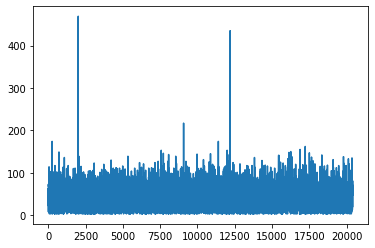

In [ ]:
text_len = []
for txt in eval_text:
  text_len.append(len(txt))

plt.plot(text_len)
plt.show()

In [ ]:
MAX_LEN = 150
eval_input_ids = pad_sequences(eval_text,
                          maxlen=MAX_LEN, dtype="long", value=0.0,
                          truncating="post", padding="post")
eval_input_ids[:2]

array([[  101,  4207,  1998,  5664,  7403,  3891,  5876,  2005,  5593,
         1011, 14447,  1998,  4639,  1011, 14447, 26180,  1024, 13458,
         1011,  2898,  1998, 24051,  8462,  1011,  2898,  2913,  7403,
         3891,  5876,  2005,  4639,  1011, 14447, 26180,  2024,  4321,
         1037, 16745,  1997,  1996,  7403,  3891,  2005,  5593,  1011,
        14447, 26180,  2021,  2007,  3452,  3760,  3896,  1010,  9104,
         1037,  3618,  2535,  2005,  2512,  1011,  7403,  3891,  5876,
         1999,  4639,  1011, 14447, 26180,   102,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
      

In [ ]:
eval_inputs = torch.tensor(eval_input_ids).cuda()
print(len(eval_inputs), len(eval_inputs[0]))

20404 150


In [ ]:
bs = 32
eval_data = TensorDataset(eval_inputs)
eval_sampler = SequentialSampler(eval_data)
eval_dataloader = DataLoader(eval_data, sampler=eval_sampler, batch_size=bs)

In [ ]:
# Put the model into evaluation mode
model.eval()
total_labels , total_tokens = [], []
for batch in eval_dataloader:
    b_input_ids = batch[0]
    #print(b_input_ids)

    # Telling the model not to compute or store gradients,
    # saving memory and speeding up validation
    with torch.no_grad():
        # Forward pass, calculate logit predictions.
        # This will return the logits rather than the loss because we have not provided labels.
        output = model(b_input_ids)
    # Move logits and labels to CPU
    label_indices = np.argmax(output[0].to('cpu').numpy(), axis=2)

    # join bpe split tokens
    tokens = tokenizer.convert_ids_to_tokens(b_input_ids.to('cpu').numpy()[0])
    new_tokens, new_labels = [], []
    for token, label_idx in zip(tokens, label_indices[0]):
        if token.startswith("##"):
            new_tokens[-1] = new_tokens[-1] + token[2:]
        else:
            new_labels.append(tag_values[label_idx])
            new_tokens.append(token)
    total_labels += new_labels
    total_tokens += new_tokens

In [ ]:
with open(input_dir+'output_new_val_0715.txt', 'w') as f:
  for token, label in zip(total_tokens, total_labels):
    print(token, label, file=f, sep='\t')